
<font size = "5"> **Day 1: [Atomic Resolution STEM and Machine Learning](../MLSTEM2025.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />


[Download](https://github.com/gduscher/MLSTEM2025/raw/refs/heads/main/Day%201/2_AberrationCorrection.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
   https://colab.research.google.com/github/gduscher/MLSTEM2025/blob/main/Day%201/2_AberrationCorrection.ipynb)
   


# Aberration Correction 

part of the workshop of 

<font size = "5"> **[Machine Learning in Transmission Electron Microscopy](../_MLSTEM.ipynb)**</font>


**Day1: Aberrations and Atomic Resolution STEM,**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
    <td></td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**May 2025**

Contributer to Notebook: Utkarsh Pratish

## Import packages for figures and 
First we load the code to make figures from pyTEMlib
### Check Installed Packages




   import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2025.4.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')

In [ ]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2025.4.1':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')

### Load necessary packages

In [1]:
%matplotlib widget
import matplotlib.pylab as plt
import numpy  as np

import pyTEMlib
import pyTEMlib.probe_tools
pyTEMlib.__version__


You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled


'0.2025.04.0'

### Load Remote Control Packages

This notebook needs a jupyter kernel of python 3.10 for Autoscript compatibility

<div class="alert alert-block alert-info">
<b>Tip:</b> Please note that the AutoScrip and CEOSacquisition are not freely available.
</div>
If you have the packages installed on your computer you need to include the path to the system (sys.path.insert)

Otherewise don't run the Autoscript and CEOS code cells

In [3]:
import sys
sys.path.insert(0, "..//..//Autoscript//")
from autoscript_tem_microscope_client import TemMicroscopeClient
from autoscript_tem_microscope_client.enumerations import *
from autoscript_tem_microscope_client.structures import *
from autoscript_tem_microscope_client.structures import RunOptiStemSettings

sys.path.insert(0, "..//..//pyAutoMic//TEM//stemOrchestrator")
from stemOrchestrator.acquisition import CEOSAcquisitionTCP

## Connection to our microscope

We connect to 
- Autoscript
- CEOS SCORR server

In [4]:
ip = "10.46.217.241" 
port_ceos = 7072
port_TF = 9095

In [5]:
microscope = TemMicroscopeClient()
microscope.connect(ip, port=port_TF)
print("Connected to the microscope")
ceos_acquisition = CEOSAcquisitionTCP(host=ip, port=port_ceos)
print("Connected to CEOS SCORR on ", ceos_acquisition.host)

Client connecting to [10.46.217.241:9095]...
Client connected to [10.46.217.241:9095]
Connected to the microscope
Connected to CEOS SCORR on  10.46.217.241


## Check Vacuum

In [6]:
print("microscope vacumm is:",microscope.vacuum.state)
print("column valve is: ", microscope.vacuum.column_valves.state)

microscope vacumm is: Ready
column valve is:  Opened


### Open column valve
If everything is okay we can open the column valve

In [61]:
microscope.vacuum.column_valves.open()

StagePosition(x=-14.19141, y=57.341274, z=-65.69379, a=-3.136)


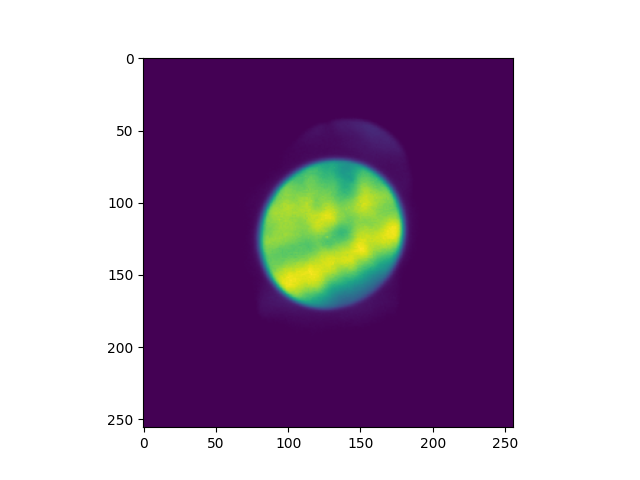

In [62]:
microscope.specimen.stage.relative_move([0,0, 0e-6])
print(microscope.specimen.stage.position*1e6)
image = microscope.acquisition.acquire_camera_image("Flucam", 1024, .02);
plt.figure()
plt.imshow(image.data[384:640, 384:640])

## Focus with Sample Height

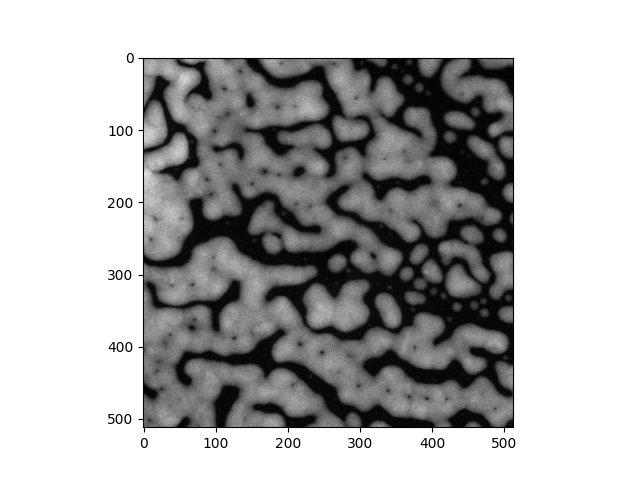

In [65]:
#microscope.specimen.stage.relative_move([0, .1*1e-6, 0*1e-6])
#microscope.optics.defocus = -0e-9
microscope.optics.scan_field_of_view  = .17*1e-6
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 4e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data, cmap='gray')



## Aberration Correction

Here we are using the tableau function of the CEOS SCORR software.

- tabtype can be "Fast", "Standard", "Enhanced"
- angle is in mili-radian
- We want the first orders from this defocus=C1=C$_{1,0}$, astigmatismus A1,B2, A2

### Correcting 1st and 2nd orders

In [66]:
microscope.optics.unblank()
microscope.optics.scan_field_of_view  = 348*1e-9

tableau_result_12 = ceos_acquisition.run_tableau(tab_type="Fast", angle=1)
def carth2polar(z):
    return np.linalg.norm(z), np.degrees(np.arctan2(z[1], z[0]))
    
for key in ['C1', 'A1', 'B2', 'A2']:
    amplitude , angle = carth2polar(tableau_result_12['aberrations'][key])                                         
    print(f" {key}: {amplitude*1e9:.2f}nm {angle:.2f}deg")
print(f" WD: {np.linalg.norm(tableau_result_12['aberrations']['WD'])*1e3:.3f}mrad ")

 C1: 14.37nm 0.00deg
 A1: 2.16nm -78.71deg
 B2: 27.16nm 119.87deg
 A2: 34.05nm 4.73deg
 WD: 0.565mrad 


In [67]:
def correct_low_orders(aberrations):
    ceos_acquisition.correct_aberration("C1", value=aberrations['C1'])
    ceos_acquisition.correct_aberration("A1", value=aberrations['A1'])
    corrected = []
    if np.linalg.norm(aberrations['A2']) >50e-9:
        ceos_acquisition.correct_aberration("A2", value=aberrations['A2'])
        corrected.append('A2')
    if np.linalg.norm(aberrations['B2']) >50e-9:
        ceos_acquisition.correct_aberration("B2", value=aberrations['B2'])
        corrected.append('B2')
    ceos_acquisition.correct_aberration("WD", value=aberrations['WD'])
    return corrected

correct_low_orders(tableau_result_12['aberrations'])


[]

In [45]:
corrected = ['1']
while len(corrected)>0:
    tableau_result_12 = ceos_acquisition.run_tableau(tab_type="Fast", angle=1)
    corrected = correct_low_orders(tableau_result_12['aberrations'])
    print(corrected)

print('done')

['A2', 'B2']
['A2', 'B2']
[]


### Correct 3rd and 4th order Aberrations
We do the tableau with a much larger angle now, and with much more different angles ('Enhanced')

In [68]:
microscope.optics.scan_field_of_view  = 348*1e-9
microscope.optics.unblank()

tableau_result = ceos_acquisition.run_tableau(tab_type="Enhanced", angle=40)# use "Fast", "Standard", "Enhanced" --angle is in mili-radian 9,18,343

for key in ['C3', 'S3', 'A3', 'A4', 'D4', 'B4']:   
    amplitude , angle = carth2polar(tableau_result['aberrations'][key])                                         
    print(f" {key}: {amplitude*1e9:.2f}nm {angle:.2f}deg")


 C3: 109.33nm 0.00deg
 S3: 184.91nm -53.74deg
 A3: 93.68nm -148.49deg
 A4: 2772.51nm -177.28deg
 D4: 1777.36nm 28.17deg
 B4: 2926.15nm 45.52deg


We first correct 3rd orders

In [47]:
def correct_3rd_orders(aberrations):
    corrected = []
    if aberrations['C3'][0] > 350e-9:
        ceos_acquisition.correct_aberration("C3", value=[aberrations['C3'][0]*.5, 0])
        corrected.append('C3')
    print(np.linalg.norm(aberrations['S3']), 200e-9)
    if np.linalg.norm(aberrations['S3']) > 200e-9:     
        x = aberrations['S3'][0]*0.75
        y = aberrations['S3'][1]*0.75
        ceos_acquisition.correct_aberration("S3", value=[x,y])
        corrected.append('S3')
    if np.linalg.norm(aberrations['A3']) > 200e-9:
        x = aberrations['A3'][0]*0.75
        y = aberrations['A3'][1]*0.75
        ceos_acquisition.correct_aberration("A3", value=[x,y])
        corrected.append('A3')
    return corrected

def correct_4th_orders(aberrations):
    corrected = []
    if np.linalg.norm(aberrations['A4']) > 5e-6:
        x = aberrations['A4'][0]*0.5
        y = aberrations['A4'][1]*0.5
        ceos_acquisition.correct_aberration("A4", value=[x,y])
        corrected.append('A4')
    if np.linalg.norm(aberrations['D4']) > 5e-6:
        x = aberrations['D4'][0]*0.5
        y = aberrations['D4'][1]*0.5
        ceos_acquisition.correct_aberration("D4", value=[x,y])
        corrected.append('D4')
    if np.linalg.norm(aberrations['B4']) > 5e-6:
        x = aberrations['B4'][0]*0.5
        y = aberrations['B4'][1]*0.5
        ceos_acquisition.correct_aberration("B4", value=[x,y])
        corrected.append('B4')
    return corrected

corrected_aberrations = correct_3rd_orders(tableau_result['aberrations'])
if len(corrected_aberrations) < 1:
    corrected_aberrations = correct_4th_orders(tableau_result['aberrations'])
print(corrected_aberrations)

9.384024785409852e-07 2e-07
['S3', 'A3']


In [ ]:
corrected_34th = ['2']
while len(corrected_34th)>0:
    corrected = ['1']
    while len(corrected)>0:
        print('correcting 1st orders')
        tableau_result_12 = ceos_acquisition.run_tableau(tab_type="Fast", angle=1)
        corrected = correct_low_orders(tableau_result_12['aberrations'])
        print(corrected)
    tableau_result = ceos_acquisition.run_tableau(tab_type="Enhanced", angle=40)# use "Fast", "Standard", "Enhanced" --angle is in mili-radian 9,18,343
    corrected_34th = correct_3rd_orders(tableau_result['aberrations'])
    if len(corrected_34th) < 1:
        print('correcting 4th orders')       
        corrected_34th = correct_4th_orders(tableau_result['aberrations'])
    else:
        print('correcting 3rd orders')
        
    print(corrected_34th)

    

In [69]:
aberrations = pyTEMlib.probe_tools.ceos_carth_to_nion(tableau_result['aberrations'])
aberrations['Cc'] = 1e7
aberrations['acceleration_voltage'] = microscope.optics.acceleration_voltage.value
pyTEMlib.probe_tools.print_aberrations_polar(aberrations)

B2 [3.7091202659166315e-09, 1.510455483998931e-08]


### Get Image

defocus: 15.3nm
condenser stigmator amplitude: 0.03 angle: -1.3


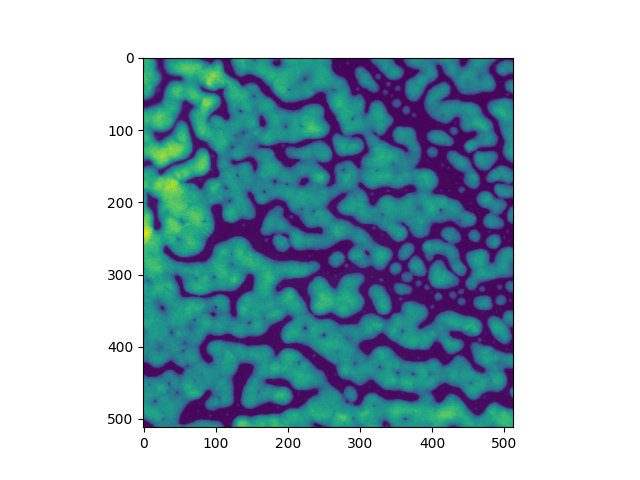

In [70]:
plt.close('all')
# microscope.optics.defocus = -27e-9
print(f"defocus: {microscope.optics.defocus*1.e9:.1f}nm")
print(f"condenser stigmator amplitude: { microscope.optics.stigmators.condenser_stigmator.magnitude():.2f}"+
      f" angle: {microscope.optics.stigmators.condenser_stigmator.angle():.1f}")
microscope.optics.scan_field_of_view  = 200*1e-9
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 16e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data)

In [17]:
microscope.optics.stigmators.condenser_stigmator.magnitude()

0.11723047385385767

### Focus and Stigmation with OptiSTEM

defocus: 12.4nm


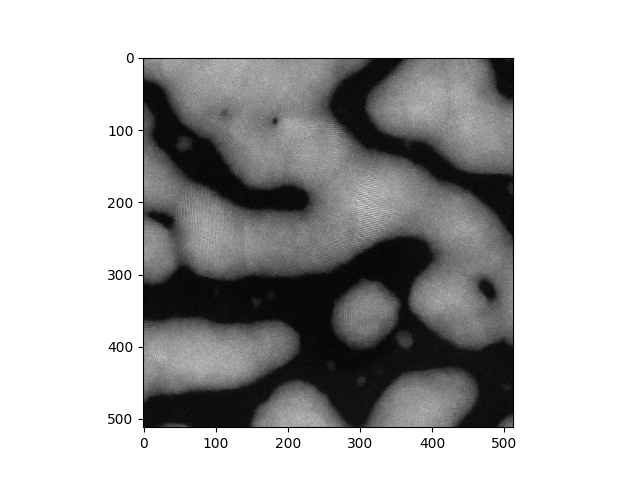

In [76]:
microscope.optics.scan_field_of_view  = 50*1e-9

settings = RunOptiStemSettings(method=OptiStemMethod.C1_A1, dwell_time=2*1e-6, cutoff_in_pixels=5)
microscope.auto_functions.run_opti_stem(settings)
print(f"defocus: {microscope.optics.defocus*1.e9:.1f}nm")
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 4e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data, cmap='gray')


### Take high resolution Image

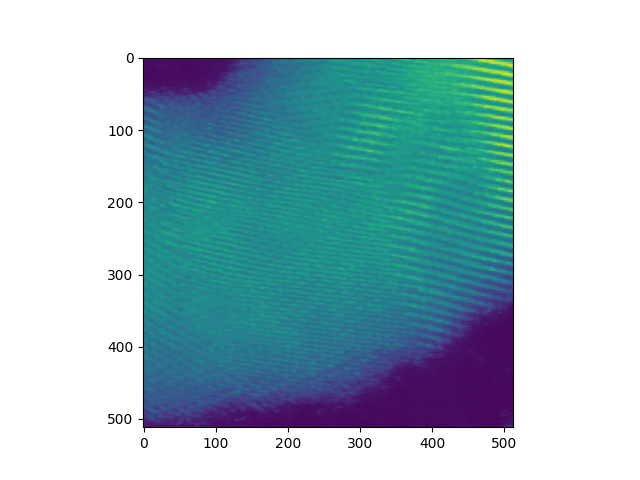

In [77]:
#microscope.optics.defocus = -39e-9
microscope.optics.scan_field_of_view  = 10*1e-9
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 16e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data)

## End Session

In [7]:
#microscope.specimen.stage.absolute_move([0,0, 0])
print(microscope.specimen.stage.position*1e6)
microscope.vacuum.column_valves.close()
print("column valve is: ", microscope.vacuum.column_valves.state)

StagePosition(x=-14.12172, y=57.27435, z=-65.12061, a=-3.136)
column valve is:  Closed


## Conclusions

Remote Aberration Correciton is not ay faster - Some Mahcine Learning has to happen - 

but it allows to adopt workflows that work for your microscope
